This study focuses on forecasting daily sunspots through the application of time series analysis. I have used the dataset spanning from the link https://www.kaggle.com/datasets/abhinand05/daily-sun-spot-data-1818-to-2019/data. The dataset undergoes thorough preprocessing, including feature selection and scaling, to enhance predictive accuracy. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.api as sm
from statsmodels.tsa.api import VAR

mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] = False


In [2]:
dataset = pd.read_csv('/kaggle/input/sunspot/sunspot_data.csv')
dataset.head()

,Unnamed: 0,Year,Month,Day,Date In Fraction Of Year,Number of Sunspots,Standard Deviation,Observations,Indicator
0,0,1818,1,1,1818.001,-1,-1.0,0,1
1,1,1818,1,2,1818.004,-1,-1.0,0,1
2,2,1818,1,3,1818.007,-1,-1.0,0,1
3,3,1818,1,4,1818.010,-1,-1.0,0,1
4,4,1818,1,5,1818.012,-1,-1.0,0,1


In [3]:
#Let's remove the repeated index column from the data
dataset.drop('Unnamed: 0', axis = 1, inplace = True)

In [4]:
dataset.shape

(73718, 8)

In [5]:
#Let's check if there's any missing values in the data
dataset.isna().sum()

Year                        0
Month                       0
Day                         0
Date In Fraction Of Year    0
Number of Sunspots          0
Standard Deviation          0
Observations                0
Indicator                   0
dtype: int64

In [6]:
#The missing values of number of sunspots is denoted by -1, so dataset.isna().sum() didn't find any missing values.
sum(dataset['Number of Sunspots'] == -1)

3247

In [7]:
# We have 3247 missing values. Let's drop them
dataset = dataset.drop(dataset[dataset['Number of Sunspots'] == -1].index)

In [8]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 70471 entries, 7 to 73717
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Year                      70471 non-null  int64  
 1   Month                     70471 non-null  int64  
 2   Day                       70471 non-null  int64  
 3   Date In Fraction Of Year  70471 non-null  float64
 4   Number of Sunspots        70471 non-null  int64  
 5   Standard Deviation        70471 non-null  float64
 6   Observations              70471 non-null  int64  
 7   Indicator                 70471 non-null  int64  
dtypes: float64(2), int64(6)
memory usage: 4.8 MB


In [9]:
dataset.describe()

,Year,Month,Day,Date In Fraction Of Year,Number of Sunspots,Standard Deviation,Observations,Indicator
count,70471.000000,70471.000000,70471.000000,70471.000000,70471.000000,70471.000000,70471.000000,70471.000000
mean,1922.314683,6.516553,15.710817,1922.814074,82.946247,7.289718,4.633778,0.998255
std,56.591214,3.423415,8.800522,56.591651,77.252109,4.567518,8.004843,0.041742
min,1818.000000,1.000000,1.000000,1818.021000,0.000000,0.000000,1.000000,0.000000
25%,1875.000000,4.000000,8.000000,1875.126000,21.000000,3.500000,1.000000,1.000000
50%,1923.000000,7.000000,16.000000,1923.363000,63.000000,6.800000,1.000000,1.000000
75%,1971.000000,9.000000,23.000000,1971.597500,127.000000,10.200000,1.000000,1.000000
max,2019.000000,12.000000,31.000000,2019.832000,528.000000,77.700000,60.000000,1.000000


In [10]:
dataset.head()

,Year,Month,Day,Date In Fraction Of Year,Number of Sunspots,Standard Deviation,Observations,Indicator
7,1818,1,8,1818.021,65,10.2,1,1
12,1818,1,13,1818.034,37,7.7,1,1
16,1818,1,17,1818.045,77,11.1,1,1
17,1818,1,18,1818.048,98,12.6,1,1
18,1818,1,19,1818.051,105,13.0,1,1


In [11]:
# Convert to datetime
dataset['Date'] = pd.to_datetime(dataset[['Year', 'Month', 'Day']])
indexedDataset = dataset.set_index(['Date'])

In [12]:
from datetime import datetime
indexedDataset.head()

,Year,Month,Day,Date In Fraction Of Year,Number of Sunspots,Standard Deviation,Observations,Indicator
Date,,,,,,,,
1818-01-08,1818,1,8,1818.021,65,10.2,1,1
1818-01-13,1818,1,13,1818.034,37,7.7,1,1
1818-01-17,1818,1,17,1818.045,77,11.1,1,1
1818-01-18,1818,1,18,1818.048,98,12.6,1,1
1818-01-19,1818,1,19,1818.051,105,13.0,1,1


<Axes: xlabel='Date In Fraction Of Year'>

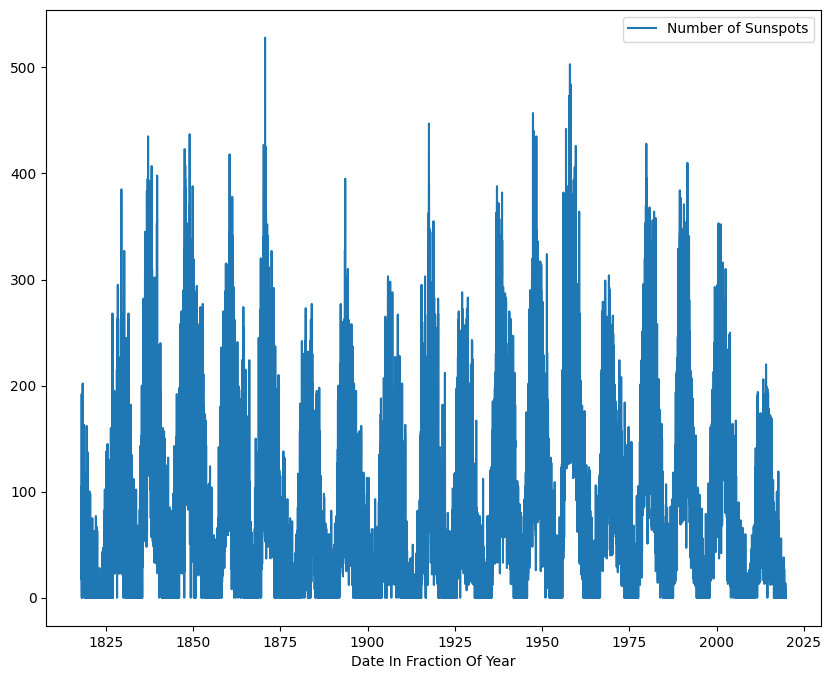

In [13]:
#Sunspots distribution
dataset.plot('Date In Fraction Of Year', 'Number of Sunspots')

In [14]:
#From above plot we can see that the number of sunspots changes periodically.
#It reaches maximum in approximately every 11 years.

In [15]:
#Let's see the correlations
y1 = dataset['Number of Sunspots']
X1 = dataset.drop(columns=['Number of Sunspots'])
#correlation X~y
corr_X1 = X1.corrwith(y1)
corr_X1.sort_values(ascending = False)

Standard Deviation          0.831973
Date                        0.064322
Date In Fraction Of Year    0.064322
Year                        0.064302
Indicator                   0.044474
Month                       0.003905
Day                        -0.000028
Observations               -0.057121
dtype: float64

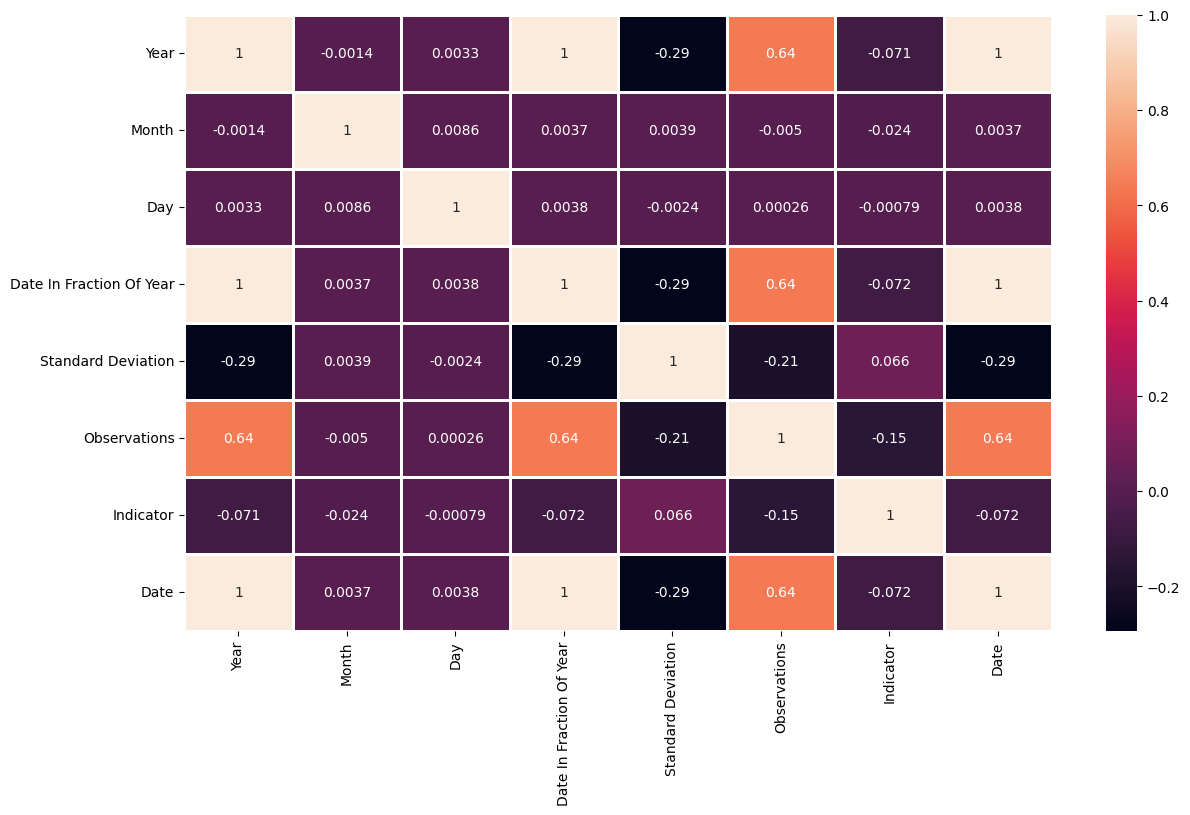

In [16]:
#correlation matrix X~X
import seaborn as sns
plt.figure(figsize=(14, 8))
#correlation heatmap
sns.heatmap(X1.corr(), annot = True, linewidth = 1)
plt.show()

In [17]:
corr_dataset = dataset.corr()
corr_dataset

,Year,Month,Day,Date In Fraction Of Year,Number of Sunspots,Standard Deviation,Observations,Indicator,Date
Year,1.000000,-0.001386,0.003305,0.999987,0.064302,-0.293004,0.637660,-0.071440,0.999987
Month,-0.001386,1.000000,0.008554,0.003660,0.003905,0.003890,-0.005003,-0.024177,0.003660
Day,0.003305,0.008554,1.000000,0.003774,-0.000028,-0.002414,0.000263,-0.000795,0.003773
Date In Fraction Of Year,0.999987,0.003660,0.003774,1.000000,0.064322,-0.292983,0.637629,-0.071561,1.000000
Number of Sunspots,0.064302,0.003905,-0.000028,0.064322,1.000000,0.831973,-0.057121,0.044474,0.064322
Standard Deviation,-0.293004,0.003890,-0.002414,-0.292983,0.831973,1.000000,-0.205721,0.066267,-0.292982
Observations,0.637660,-0.005003,0.000263,0.637629,-0.057121,-0.205721,1.000000,-0.148856,0.637633
Indicator,-0.071440,-0.024177,-0.000795,-0.071561,0.044474,0.066267,-0.148856,1.000000,-0.071561
Date,0.999987,0.003660,0.003773,1.000000,0.064322,-0.292982,0.637633,-0.071561,1.000000


In [18]:
# Since the time series analysis requires stationarity of the data, we will first check the stationarity of the data.
# Any kind of  statistical model that you apply on time series, data should be stationary. Most of the models works on the assumption that the time series is stationary.
# When a time series has particular behaviour over time it is called stationarity, there is a very high probability it will follow the same in the future.
# The conditions for stationarity are constant mean, constant variance, autocovariance that does not depend on time.
# There are two pouplar test in python to check the stationarity.

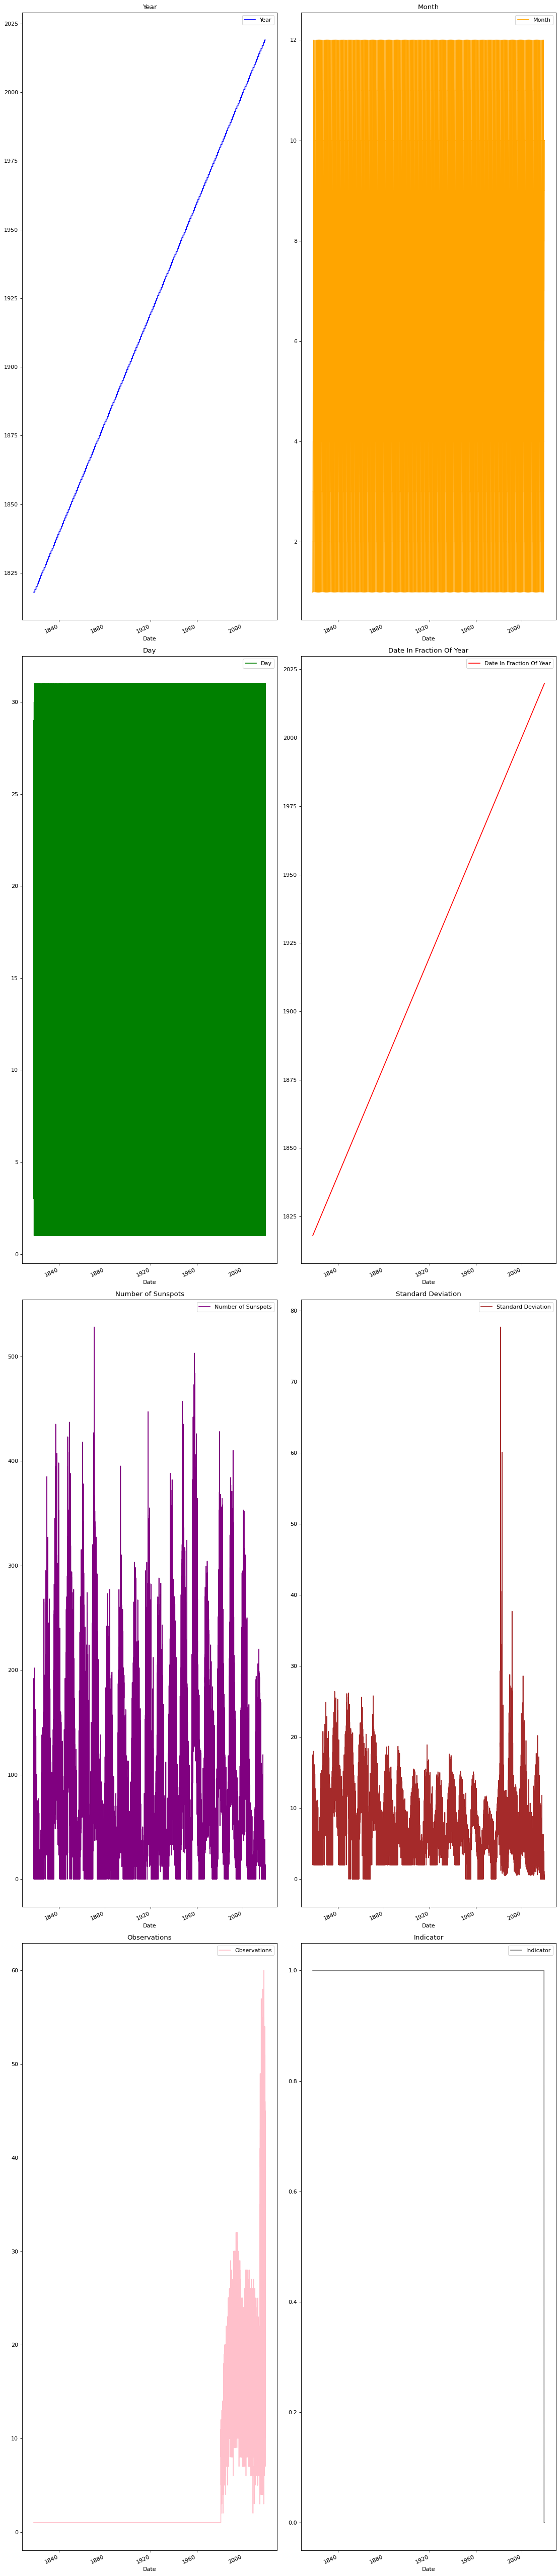

In [19]:
color_list = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

def Visualize(data):
    features = list(indexedDataset.select_dtypes(include = [np.number]).columns.values)
    feature_size = len(features)
    fig, axes = plt.subplots(nrows = int(np.ceil(feature_size/2)), ncols = 2, figsize = (14, feature_size**2), dpi = 80, facecolor = "w", edgecolor = "k")
    for i in range(feature_size):
        key = features[i]
        c = color_list[i % (len(color_list))]
        t_data = data[key]
        t_data.head()
        ax = t_data.plot( ax = axes[i // 2, i % 2], color = c, title = "{}".format(key), rot = 25,)
        ax.legend([key])
    plt.tight_layout()
    
    
Visualize(indexedDataset)

Augmented Dickey-Fuller Test
Null Hypothes- Series possesses a unit root and hence is not stationary
Alternate Hypothesis- Series is stationary

In [20]:
for i in range(len(indexedDataset.columns)):
    result = adfuller(indexedDataset[indexedDataset.columns[i]])
    if result[1] > 0.05:
        print('{} - Series is not Stationary'. format(indexedDataset.columns[i]))
    else:
        print('{} - Series is Stationary'. format(indexedDataset.columns[i]))
        

Year - Series is not Stationary
Month - Series is Stationary
Day - Series is Stationary
Date In Fraction Of Year - Series is Stationary
Number of Sunspots - Series is Stationary
Standard Deviation - Series is Stationary
Observations - Series is not Stationary
Indicator - Series is not Stationary


In [21]:
# We need make Observations, Year and Indicator stationary before applying VAR method.

seasonal_period = 11  # Since there is 11 years cycle
indexedDataset['seasonal_Year'] = indexedDataset['Year'].diff(seasonal_period).dropna()

indexedDataset['seasonal_Observations'] = indexedDataset['Observations'].diff(seasonal_period).dropna()


indexedDataset['seasonal_Indicator'] = indexedDataset['Indicator'].diff(seasonal_period).dropna()



indexedDataset.head()

,Year,Month,Day,Date In Fraction Of Year,Number of Sunspots,Standard Deviation,Observations,Indicator,seasonal_Year,seasonal_Observations,seasonal_Indicator
Date,,,,,,,,,,,
1818-01-08,1818,1,8,1818.021,65,10.2,1,1,NaN,NaN,NaN
1818-01-13,1818,1,13,1818.034,37,7.7,1,1,NaN,NaN,NaN
1818-01-17,1818,1,17,1818.045,77,11.1,1,1,NaN,NaN,NaN
1818-01-18,1818,1,18,1818.048,98,12.6,1,1,NaN,NaN,NaN
1818-01-19,1818,1,19,1818.051,105,13.0,1,1,NaN,NaN,NaN


In [22]:
indexedDataset.dropna(inplace = True)

In [23]:
indexedDataset.head()

,Year,Month,Day,Date In Fraction Of Year,Number of Sunspots,Standard Deviation,Observations,Indicator,seasonal_Year,seasonal_Observations,seasonal_Indicator
Date,,,,,,,,,,,
1818-02-09,1818,2,9,1818.108,87,11.8,1,1,0.0,0.0,0.0
1818-02-13,1818,2,13,1818.119,192,17.5,1,1,0.0,0.0,0.0
1818-02-14,1818,2,14,1818.122,73,10.8,1,1,0.0,0.0,0.0
1818-02-15,1818,2,15,1818.125,82,11.4,1,1,0.0,0.0,0.0
1818-02-16,1818,2,16,1818.127,28,6.7,1,1,0.0,0.0,0.0


In [24]:
indexedDataset = indexedDataset.drop(['Year', 'Indicator', 'Observations'], axis =1)

In [25]:
indexedDataset.head()

,Month,Day,Date In Fraction Of Year,Number of Sunspots,Standard Deviation,seasonal_Year,seasonal_Observations,seasonal_Indicator
Date,,,,,,,,
1818-02-09,2,9,1818.108,87,11.8,0.0,0.0,0.0
1818-02-13,2,13,1818.119,192,17.5,0.0,0.0,0.0
1818-02-14,2,14,1818.122,73,10.8,0.0,0.0,0.0
1818-02-15,2,15,1818.125,82,11.4,0.0,0.0,0.0
1818-02-16,2,16,1818.127,28,6.7,0.0,0.0,0.0


In [26]:
# Let's check the stationarity again.
for i in range(len(indexedDataset.columns)):
    result = adfuller(indexedDataset[indexedDataset.columns[i]])
    if result[1] > 0.05:
        print('{} - Series is not Stationary'. format(indexedDataset.columns[i]))
    else:
        print('{} - Series is Stationary'. format(indexedDataset.columns[i]))
        


Month - Series is Stationary
Day - Series is Stationary
Date In Fraction Of Year - Series is Stationary
Number of Sunspots - Series is Stationary
Standard Deviation - Series is Stationary
seasonal_Year - Series is Stationary
seasonal_Observations - Series is Stationary
seasonal_Indicator - Series is Stationary


In [27]:
# Since all of our series have become stationary, we can now apply VAR technique.
# But before we apply VAR, Let's which variable are more responsible fo Number of Sunspots. We can drop the variables with High P value.

In [28]:
max_lags = 10
y = 'Number of Sunspots'

In [29]:
indexedDataset.head()

,Month,Day,Date In Fraction Of Year,Number of Sunspots,Standard Deviation,seasonal_Year,seasonal_Observations,seasonal_Indicator
Date,,,,,,,,
1818-02-09,2,9,1818.108,87,11.8,0.0,0.0,0.0
1818-02-13,2,13,1818.119,192,17.5,0.0,0.0,0.0
1818-02-14,2,14,1818.122,73,10.8,0.0,0.0,0.0
1818-02-15,2,15,1818.125,82,11.4,0.0,0.0,0.0
1818-02-16,2,16,1818.127,28,6.7,0.0,0.0,0.0


In [30]:
for i in range(len(indexedDataset.columns)):
    results = grangercausalitytests(indexedDataset[[y, indexedDataset.columns[i]]], max_lags, verbose = False)
    p_values = [round(results[i+1][0]['ssr_ftest'][1],4) for i in range(max_lags)]
    print('Column - {} : P_Values - {}'.format(indexedDataset.columns[i], p_values))

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Column - Month : P_Values - [0.7501, 0.3596, 0.5636, 0.7227, 0.7717, 0.8524, 0.8071, 0.8631, 0.8805, 0.9314]


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Column - Day : P_Values - [0.6279, 0.678, 0.7815, 0.8365, 0.6495, 0.7441, 0.8271, 0.8527, 0.6954, 0.7411]


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Column - Date In Fraction Of Year : P_Values - [0.0108, 0.0006, 0.0008, 0.0021, 0.0015, 0.0007, 0.0005, 0.0017, 0.0022, 0.0029]


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Column - Number of Sunspots : P_Values - [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Column - Standard Deviation : P_Values - [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Column - seasonal_Year : P_Values - [0.389, 0.6565, 0.8349, 0.9177, 0.8817, 0.934, 0.964, 0.9581, 0.955, 0.9697]


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Column - seasonal_Observations : P_Values - [0.5118, 0.7362, 0.8003, 0.822, 0.868, 0.916, 0.9466, 0.9794, 0.9781, 0.9719]


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Column - seasonal_Indicator : P_Values - [0.5545, 0.8536, 0.9522, 0.9854, 0.9958, 0.9989, 0.9991, 0.9998, 1.0, 1.0]


In [31]:
#We can drop the columns Day, Seasonal_Observations and Seasonal_Indicator because of their high p-value.
df = indexedDataset[['Month', 'Date In Fraction Of Year', 'Number of Sunspots', 'Standard Deviation', 'seasonal_Year']]

In [32]:
df.head()

,Month,Date In Fraction Of Year,Number of Sunspots,Standard Deviation,seasonal_Year
Date,,,,,
1818-02-09,2,1818.108,87,11.8,0.0
1818-02-13,2,1818.119,192,17.5,0.0
1818-02-14,2,1818.122,73,10.8,0.0
1818-02-15,2,1818.125,82,11.4,0.0
1818-02-16,2,1818.127,28,6.7,0.0


In [33]:
df_train = df[:int(0.8*(len(df)))]
df_test = df[int(0.8*(len(df))):]

In [34]:
df_train.shape

(56368, 5)

In [35]:
df_test.shape

(14092, 5)

In [36]:
print(df_train.index)

DatetimeIndex(['1818-02-09', '1818-02-13', '1818-02-14', '1818-02-15',
               '1818-02-16', '1818-02-19', '1818-02-21', '1818-02-23',
               '1818-02-25', '1818-02-26',
               ...
               '1981-03-23', '1981-03-24', '1981-03-25', '1981-03-26',
               '1981-03-27', '1981-03-28', '1981-03-29', '1981-03-30',
               '1981-03-31', '1981-04-01'],
              dtype='datetime64[ns]', name='Date', length=56368, freq=None)


In [37]:
model = VAR(df_train)

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [38]:
model.select_order(16).summary()

,AIC,BIC,FPE,HQIC
0,16.41,16.41,1.340e+07,16.41
1,-14.26,-14.25,6.435e-07,-14.25
2,-14.29,-14.29,6.195e-07,-14.29
3,-14.32,-14.30,6.059e-07,-14.31
4,-14.35,-14.34,5.844e-07,-14.35
5,-14.40,-14.37,5.599e-07,-14.39
6,-14.43,-14.40,5.436e-07,-14.42
7,-14.46,-14.43,5.245e-07,-14.45
8,-14.52,-14.49,4.930e-07,-14.51
9,-14.62,-14.58,4.468e-07,-14.61


In [39]:
model = VAR(df_train)
results = model.fit(16)

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [40]:
print(results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 13, Oct, 2024
Time:                     15:19:58
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -16.2967
Nobs:                     56352.0    HQIC:                  -16.3409
Log likelihood:           61590.9    FPE:                7.84390e-08
AIC:                     -16.3609    Det(Omega_mle):     7.78777e-08
--------------------------------------------------------------------
Results for equation Month
                                  coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------------------
const                                0.417829         0.173073            2.414           0.016
L1.Month                             0.984306         0.011398           86.361           0.000


In [41]:
lag = results.k_ar

In [42]:
results.forecast(df_train.values[-lag:], steps = 5)

array([[ 4.09537422e+00,  1.98125059e+03,  2.29502350e+02,
         8.76349876e+00, -7.36772178e-03],
       [ 4.02147577e+00,  1.98125276e+03,  2.27477434e+02,
         9.10014418e+00, -2.34221069e-03],
       [ 4.17393869e+00,  1.98125514e+03,  2.27683276e+02,
         9.13920816e+00, -1.48734120e-02],
       [ 4.24740510e+00,  1.98125786e+03,  2.24821975e+02,
         9.57526328e+00, -2.61141194e-02],
       [ 4.36300110e+00,  1.98126032e+03,  2.20161558e+02,
         9.57533010e+00, -4.84217882e-02]])

In [43]:
df_test[0:5]

,Month,Date In Fraction Of Year,Number of Sunspots,Standard Deviation,seasonal_Year
Date,,,,,
1981-04-02,4,1981.251,245,18.5,0.0
1981-04-03,4,1981.253,213,13.0,0.0
1981-04-04,4,1981.256,218,15.3,0.0
1981-04-05,4,1981.259,210,10.5,0.0
1981-04-06,4,1981.262,190,9.1,0.0


In [44]:
# If we compare the forecast data with this table, we see that the prediction very close to the test data.

In [45]:
#Time series Forcasting with XGBoost
#Although our data is stationary, XGBoost does not necessarily require stationary time series data.

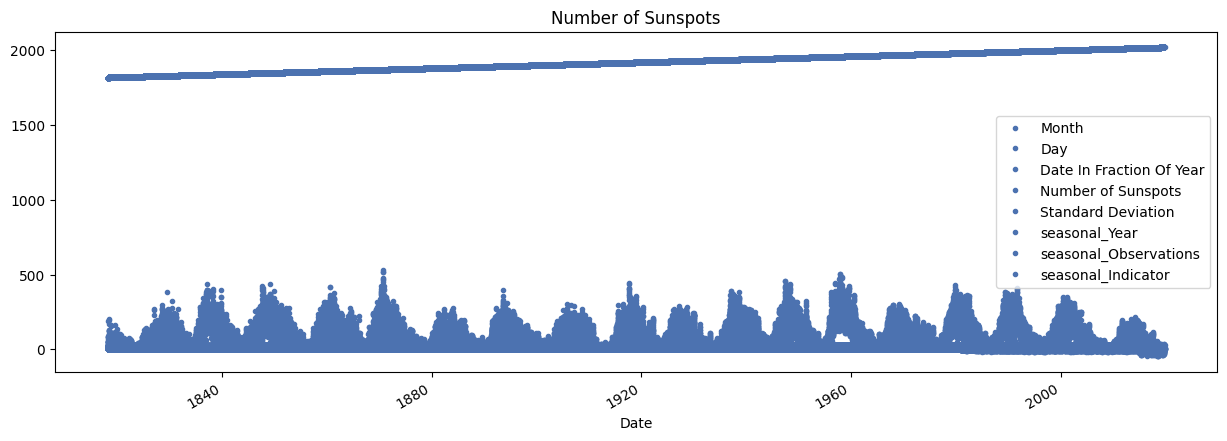

In [46]:
color_pal = sns.color_palette("deep")
indexedDataset.plot(style = '.', figsize = (15, 5), color = color_pal[0], title = 'Number of Sunspots')
plt.show()

In [47]:
#Train/Test/Split

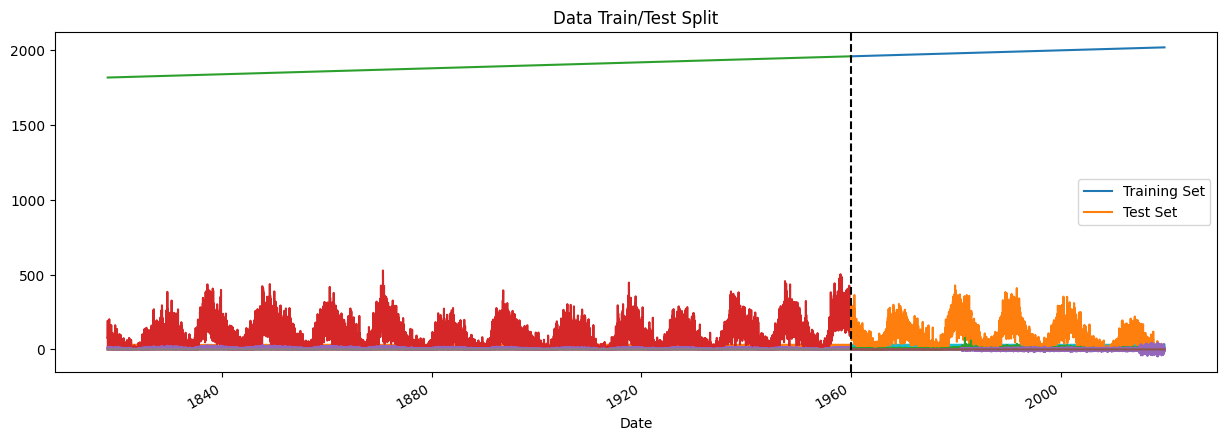

In [48]:
train = indexedDataset.loc[indexedDataset.index <'1960-01-01']
test = indexedDataset.loc[indexedDataset.index >='1960-01-01']
fig, ax = plt.subplots(figsize = (15, 5))
train.plot(ax = ax, label = 'Training Set', title = 'Data Train/Test Split')
test.plot(ax = ax, label = 'Test Set')
ax.axvline ('1960-01-01', color = 'black', ls = '--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

<Axes: xlabel='Date'>

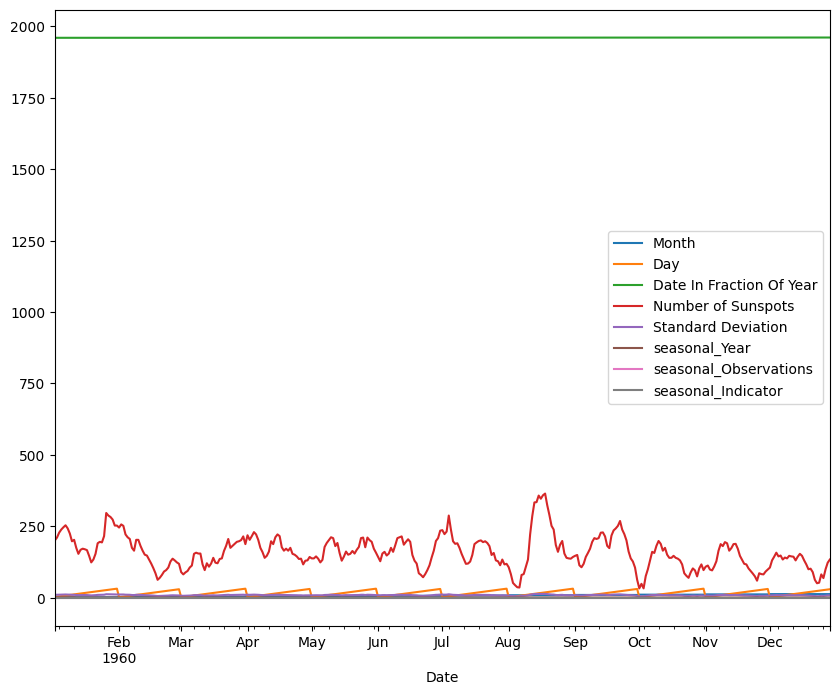

In [49]:
# Let's see how our data looks like in a year.
indexedDataset.loc[(indexedDataset.index >'1960-01-01') & (indexedDataset.index < '1960-12-30')].plot()

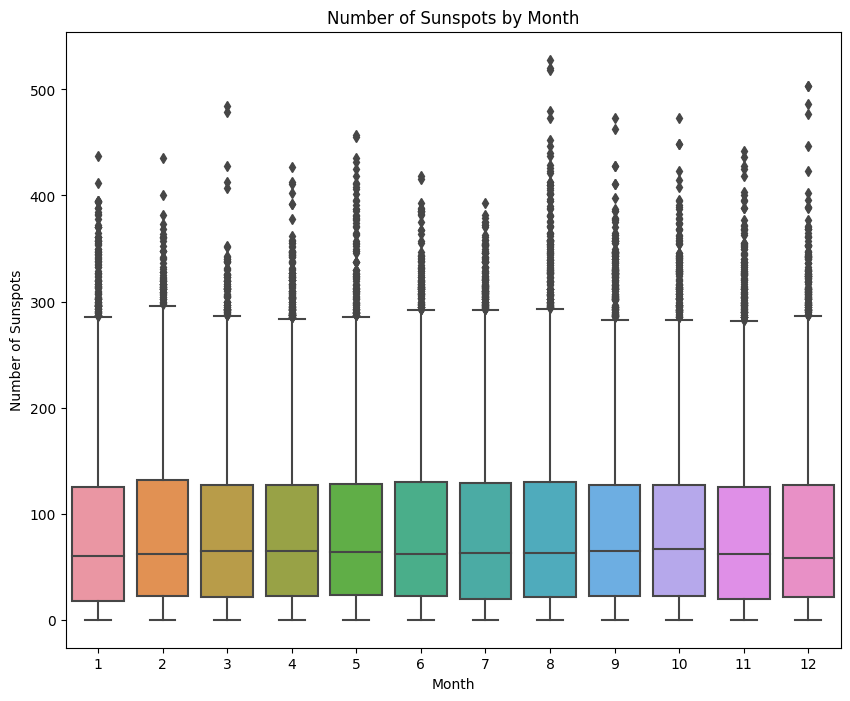

In [50]:
fig, ax = plt.subplots(figsize = (10, 8))
sns.boxplot(data = indexedDataset, x = 'Month', y = 'Number of Sunspots')
ax.set_title('Number of Sunspots by Month')
plt.show()

In [51]:
X_train = indexedDataset.drop('Number of Sunspots', axis = 1).loc[indexedDataset.index <'1960-01-01']
y_train = indexedDataset['Number of Sunspots'].loc[indexedDataset.index <'1960-01-01']

X_test = indexedDataset.drop('Number of Sunspots', axis = 1).loc[indexedDataset.index >='1960-01-01']
y_test = indexedDataset['Number of Sunspots'].loc[indexedDataset.index >='1960-01-01']

In [52]:
#Create our Model
reg = xgb.XGBRegressor(base_score = 0.5, booster = 'gbtree', n_estimators = 1000,  early_stopping_rounds = 50, objective ='reg:linear', max_depth = 3, learning_rate = 0.001)
reg.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_test, y_test)], verbose = 100)

[0]	validation_0-rmse:112.56730	validation_1-rmse:113.57252


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:23:01] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:102.71405	validation_1-rmse:101.99047
[200]	validation_0-rmse:93.85378	validation_1-rmse:91.89092
[300]	validation_0-rmse:85.82572	validation_1-rmse:83.33794
[400]	validation_0-rmse:78.53007	validation_1-rmse:76.32577
[500]	validation_0-rmse:71.87202	validation_1-rmse:70.27503
[600]	validation_0-rmse:65.84632	validation_1-rmse:64.98632
[700]	validation_0-rmse:60.38461	validation_1-rmse:60.44821
[800]	validation_0-rmse:55.41142	validation_1-rmse:56.48154
[900]	validation_0-rmse:50.84901	validation_1-rmse:53.12482
[999]	validation_0-rmse:46.74696	validation_1-rmse:50.53090


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.001, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [53]:
test['prediction'] = reg.predict(X_test)
Score = np.sqrt(mean_squared_error(test['Number of Sunspots'], test['prediction']))
print(f'RMSE Score on Test set: {Score:0.2f}')

RMSE Score on Test set: 50.53


/tmp/ipykernel_347/2769981058.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = reg.predict(X_test)


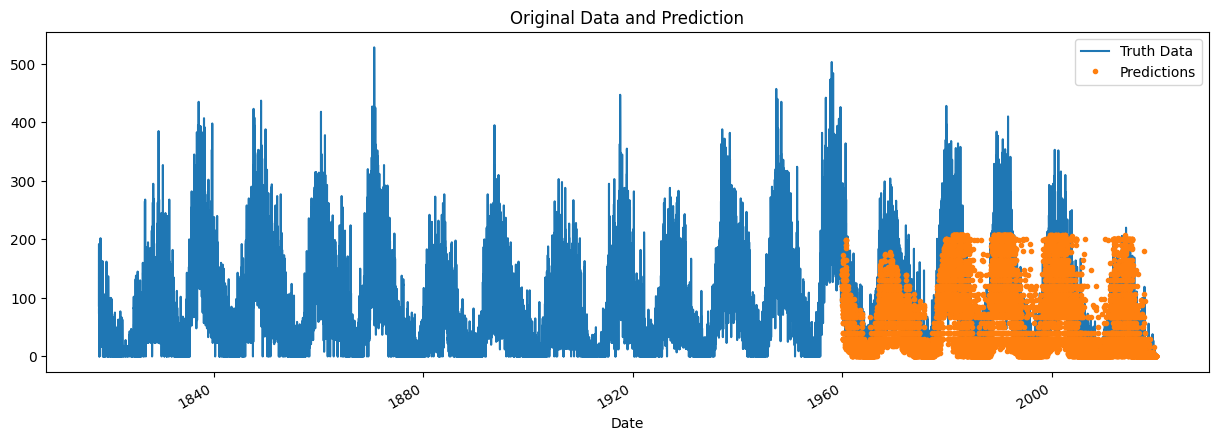

In [54]:
indexedDataset = indexedDataset.merge(test[['prediction']], how = 'left', left_index = True, right_index = True)
ax = indexedDataset['Number of Sunspots'].plot(figsize = (15, 5))
indexedDataset['prediction'].plot(ax = ax, style = '.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Original Data and Prediction')
plt.show()

# References:

1. Daily Sun Spot Data (1818 to 2019). https://www.kaggle.com/datasets/abhinand05/daily-sun-spot-data-1818-to-2019/data

2. T. Khan, F. Arafat, M. U. Mojumdar, A. Rajbongshi, S. M. T. Siddiquee and N. R. Chakraborty, "A Machine Learning Approach for Predicting the Sunspot of Solar Cycle," 2020 11th International Conference on Computing, Communication and Networking Technologies (ICCCNT), Kharagpur, India, 2020, pp. 1-4, doi: 10.1109/ICCCNT49239.2020.9225427.

3.  “Time Series Analysis in Python | Time Series Forecasting | Data Science with Python | Edureka.” YouTube, uploaded by edureka!
, 31 May 2023, https://www.youtube.com/watch?v=e8Yw4alG16Q&t=79s.

4. Time Series Forecasting with Machine Learning [YT]
https://www.kaggle.com/code/robikscube/time-series-forecasting-with-machine-learning-yt